# Visualize Predictions, Precision/Recall Curves, Training Loss

In [24]:
# visualize() renders predictions of crops/images
# stores them under models/<S@N@A@RES>/<modelseries name>/playground/<checkpoint>/<conf_tresh>

import torch
import torchvision.models as models
import model as m
import dataset as d
import eval
import util
import config as c
import ModelSeries as ms
from importlib import reload
import os
reload(eval)
reload(util)
reload(d)
reload(m)
reload(ms)

def visualize(gt_df, series, conf_thr = 0.1):
    eval_dataset = d.CroppedDataset(gt_df, mode = "val")
    print(f"debug visualize: len(eval_dataset): {len(eval_dataset)}")
    series.model.eval()
    series.model.to("cuda")

    
    dir = os.path.join(series.series_dir, "playground", f"{series.getEpoch()}")
    os.makedirs(dir, exist_ok=True)

    for i in range(20):
        idx = i * 200
        try:
            image, target = eval_dataset[idx % len(eval_dataset)]
            image, target = image.to("cuda"), target.to("cuda")
        except Exception:
            print("error loading the image")
            print(f"type image, target: {type(image), type(target)}")
            continue
        

        with torch.no_grad():
            pred = series.model(image.unsqueeze(0))  # [1, 1, H, W] -> model -> [1, N, N, A, 5+C]
            pred = pred.squeeze(0)  # [N, N, A, 5+C]

        pred = eval.logit_to_target(pred)

        iou = eval.pred_to_iou(pred, target)
        tp_mask, fp_mask, fn_mask, tgt_conf, pred_cls, tgt_cls = eval.calc_masks(pred, target, iou, conf_thr=conf_thr)
        precision, recall = eval.unit_precision_recall(tp_mask, fp_mask, fn_mask)
        

        prec = f"{precision:.4f}"
        rec = f"{recall:.4f}"
        util.render_prediction(image, pred, iou, out_dir = os.path.join(dir, f"{conf_thr}"), name = f"crop_{i}_{prec}_{rec}.png", obj_thresh=conf_thr)
    print(f"Visualization saved to {dir}")

In [ ]:
import numpy as np
from IPython.display import display
reload(util)
gt_df = util.DataExtractor().croppedData()

def demo(series, filepath, conf_thr=0.1):
    series.model.eval().to("cpu")

    demo_dir = os.path.join(os.getcwd(), "demo")
    img_path = os.path.join(demo_dir, filepath)
    if not os.path.isfile(img_path):
        print(f"File NOT found: {img_path}")
        return
    print(f"Found file: {img_path}  ({os.path.getsize(img_path)} bytes)")

    try:
        # unpack tuple from util.load_crop_image
        crop_img, *_ = util.load_crop_image(img_path, 0, 0)  # PIL Image
        # force grayscale, (H,W)
        arr = np.array(crop_img.convert("L"), dtype=np.float32) / 255.0
        # -> (1,1,H,W)
        image = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).to("cpu")
        print("image.shape:", tuple(image.shape))
    except Exception as e:
        print("error loading the image:", repr(e))
        return

    with torch.no_grad():
        pred = series.model(image)         # (1,N,N,A,5+C)
        pred = pred.squeeze(0)             # (N,N,A,5+C)
        pred = eval.logit_to_target(pred)  # decode to (tx,ty,tw,th,obj,...)

    out_dir = os.path.join(demo_dir, "preds")
    os.makedirs(out_dir, exist_ok=True)



    # render expects (H,W) or (1,H,W); give it (H,W)
    rendered = util.render_demo(
        image=image.squeeze(0).squeeze(0).to("cpu"),
        pred=pred.to("cpu"),
        obj_thresh=conf_thr,
        out_dir=out_dir,
        name=os.path.basename(filepath).replace(".", f"_thr{conf_thr}.")
    )
    print(f"Saved visualization → {out_dir}")
    display(rendered)
    return rendered


series = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode="training")
x = demo(series, r"images\diabelli.png", conf_thr=0.85 )

Saving to: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [18]:
import ModelSeries as ms
de = util.DataExtractor()
gt_df = de.croppedData()

eval_dataset = d.CroppedDataset(gt_df, mode = "val")
series = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode = "training")

#visualize(gt_df, series, conf_thr = 0.07)

Saving to: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json
val-dataset created containing 136 crops
ModelSeries: loadJsonData()
Modelseries: loadLastCheckpoint Error


# Precision and Recall

In [26]:
import eval
import ModelSeries as ms
from importlib import reload
reload(eval)
series = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode = "training")

threshs = [0.015, 0.01625, 0.0175, 0.01875, 0.02, 0.04, 0.06, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

pr_curve = []
pr2_curve = []
print("h")
for i in threshs:
    pr_curve.append(eval.avg_precision_recall(series.model, eval_dataset, "cpu", n_samples=100, conf_thr= i ))#mit 200 und len(thresh)=16 dauerts 12 Minuten
    


ModelSeries: loadJsonData()
Mode is set to training
Modelseries: loadLastCheckpoint Error
h
avg_precision called


KeyboardInterrupt: 

In [ ]:
import pickle, os, datetime
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filepath = os.path.join(os.getcwd(), "m_rec_prec_cls", f"pr_curve{ts}.pkl")

# save once after computing
with open(filepath, "wb") as f:
    pickle.dump(pr_curve, f)

In [ ]:
filepath = os.path.join(os.getcwd(), "m_rec_prec_cls", "pr_curve20250906_094409.pkl")
with open(filepath, "rb") as f:
    pr_curve = pickle.load(f)

In [ ]:
pr_curve

[(0.4593185593611165,
  0.41757976928788415,
  (25991.0000001, 36251.0000001, 30595.0000001),
  (tensor([0.5450, 0.2900, 0.2647, 0.3953, 0.4286, 0.5384, 0.3986, 0.3000, 0.6629,
           0.0000, 0.2322, 0.5714, 0.6818, 0.6761, 0.1875, 0.3333, 0.5833, 0.0000,
           0.3587, 0.0000, 0.1765, 0.5714, 0.2500, 0.6889, 0.7009, 0.0000, 0.7506,
           0.0000, 0.6016, 0.0000, 0.4492, 0.0000, 0.6047, 0.0000, 0.3043, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.4398, 0.1904, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.5144, 0.0000, 0.3214, 0.0000, 0.0000, 0.4286, 0.4713,
           0.0000, 0.5000, 0.0000, 0.0000, 0.4444, 0.1500, 0.0000, 0.5072, 0.0000,
           0.6205, 0.0000, 0.0000, 0.0000, 0.6940, 0.1818, 0.6938, 0.0000, 0.0000,
           0.1192, 0.0146, 0.0000, 0.0000, 0.5714, 0.2000, 0.0000, 0.0000, 0.7200,
           0.5000, 0.0000, 0.0000, 0.7192, 0.8000, 0.6611, 0.6193, 0.4817, 0.3409,
           0.5625, 0.5469, 0.0000, 0.3076, 0.6906, 0.5974, 0.3191, 0.2500, 0

In [ ]:
er = EvalRecord(gt_df)
er.addEvalRecord(precision_per_cls, recall_per_cls, 7)
er.df.head(20)

avg_precision called


In [ ]:
er = EvalRecord(gt_df)
er.addEvalRecord(precision_per_cls, recall_per_cls, 7)
er.df.head(20)

C:\Users\alexh\AppData\Local\Temp\ipykernel_20776\2458015298.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, df_new], ignore_index=True)


,class_id,class_name,n_occurences,n_images,epoch,mAP,mREC
0,0,brace,2879,767,7,0.972222,0.972222
1,1,ledgerLine,88316,1327,7,0.178396,0.140283
2,2,repeatDot,2786,227,7,0.000000,0.000000
3,3,segno,231,168,7,1.000000,1.000000
4,4,coda,225,219,7,1.000000,1.000000
5,5,clefG,8332,1227,7,0.977528,0.977528
6,6,clefCAlto,1015,373,7,0.818182,1.000000
7,7,clefCTenor,614,240,7,1.000000,1.000000
8,8,clefF,5405,1160,7,0.869565,0.888889
9,9,clefUnpitchedPercussion,0,0,7,0.000000,0.000000


In [ ]:
eval.avg_precision_recall(series.model, eval_dataset, "cuda", n_samples=100, conf_thr= 0.1 )

avg_zero, avg_one, avg_two: (346.64, 36.66, 16.7)
max_two: [84, 54]
avg active in anchor one vs. two: (36.66, 0.0)


(0.5296445518545987, 0.4336593578549934)

In [ ]:
pr_ = [(threshs[i], pr_curve[i]) for i in range(len(threshs))]
pr_

[(0.015,
  (0.4593185593611165,
   0.41757976928788415,
   (25991.0000001, 36251.0000001, 30595.0000001),
   (tensor([0.5450, 0.2900, 0.2647, 0.3953, 0.4286, 0.5384, 0.3986, 0.3000, 0.6629,
            0.0000, 0.2322, 0.5714, 0.6818, 0.6761, 0.1875, 0.3333, 0.5833, 0.0000,
            0.3587, 0.0000, 0.1765, 0.5714, 0.2500, 0.6889, 0.7009, 0.0000, 0.7506,
            0.0000, 0.6016, 0.0000, 0.4492, 0.0000, 0.6047, 0.0000, 0.3043, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.4398, 0.1904, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.5144, 0.0000, 0.3214, 0.0000, 0.0000, 0.4286, 0.4713,
            0.0000, 0.5000, 0.0000, 0.0000, 0.4444, 0.1500, 0.0000, 0.5072, 0.0000,
            0.6205, 0.0000, 0.0000, 0.0000, 0.6940, 0.1818, 0.6938, 0.0000, 0.0000,
            0.1192, 0.0146, 0.0000, 0.0000, 0.5714, 0.2000, 0.0000, 0.0000, 0.7200,
            0.5000, 0.0000, 0.0000, 0.7192, 0.8000, 0.6611, 0.6193, 0.4817, 0.3409,
            0.5625, 0.5469, 0.0000, 0.3076, 0.6906, 0.

In [ ]:
print(pr_[1][1][4])

IndexError: tuple index out of range

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tp, fp, fn = [x[1][2] for x in pr_], [x[1][3] for x in pr_], [x[1][4] for x in pr_]

plt.figure(figsize=(6, 4))
plt.plot(threshs, tp, marker='o', markersize = 3, label="TP")
plt.plot(threshs, fp, marker='o', markersize = 3, label="FP")
plt.plot(threshs, fn, marker='o', markersize = 3, label = "FN")
plt.xlabel("Conf Thresh")
plt.ylabel("Cases")
plt.title("Confidence Curves")
plt.grid(True)
plt.xticks(np.arange(0, 0.9, step = 0.1))
plt.tight_layout()
plt.legend()
plt.show()

IndexError: tuple index out of range

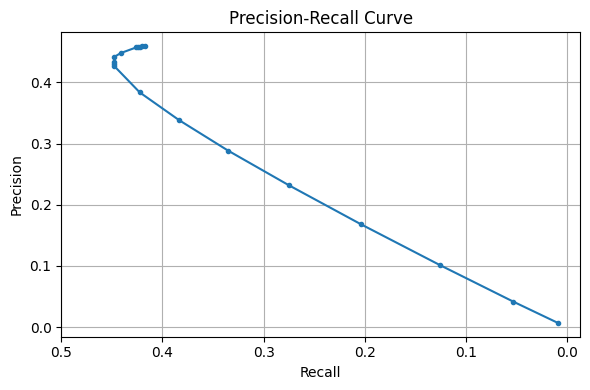

In [ ]:
precision, recall = [x[1][0] for x in pr_], [x[1][1] for x in pr_]

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='o', markersize = 3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.xticks(np.arange(0, 0.55, step = 0.1))
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

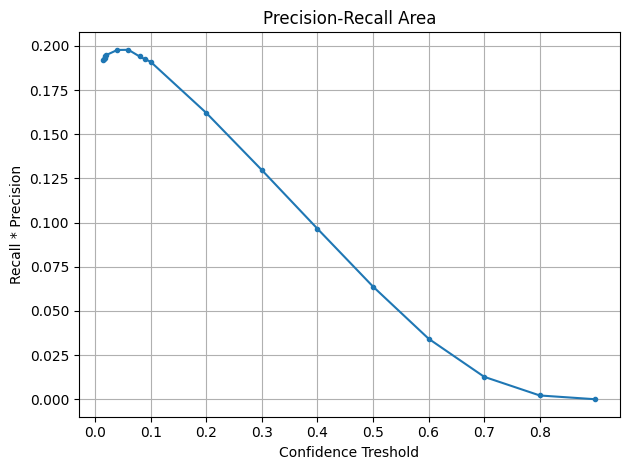

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
index, product = [i * 0.1 for i in range(10)], [x[1][1] * x[1][0] for x in pr_]

plt.figure()
plt.plot(threshs, product, marker='o', markersize = 3)
plt.xlabel("Confidence Treshold")
plt.ylabel("Recall * Precision")
plt.title("Precision-Recall Area")
plt.grid(True)
plt.tight_layout()
plt.xticks(np.arange(0, 0.9, step = 0.1))
plt.show()

# Training Losses

In [ ]:
import util, os
import ModelSeries as ms
from IPython.display import HTML, display 
import matplotlib.pyplot as plt 
import numpy as np
gt_df = util.DataExtractor().croppedData()
ms = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode="")
records = ms.records.iloc[:]
labels = "l_cls, l_noobj, l_xy, l_obj, l_wh, mAP, mREC".split(", ") 
losses = [records[k] for k in labels] 
epochs = list(range(len(losses[0])))

records["total"] = (
    records["l_cls"]
  + records["l_noobj"]
  + records["l_xy"]
  + records["l_obj"]
  + records["l_wh"]
)

# update labels + losses
labels.append("total")
losses.append(records["total"])

Saving to: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json
ModelSeries: loadJsonData()


In [ ]:
intervals = [(0, 300), (40, 125), (40, 250), (40, 300)]

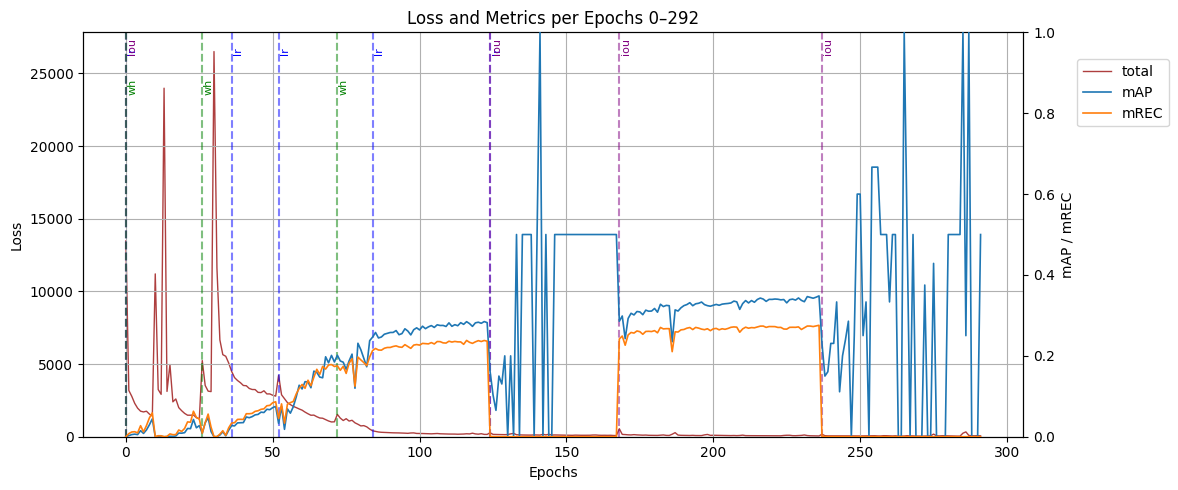

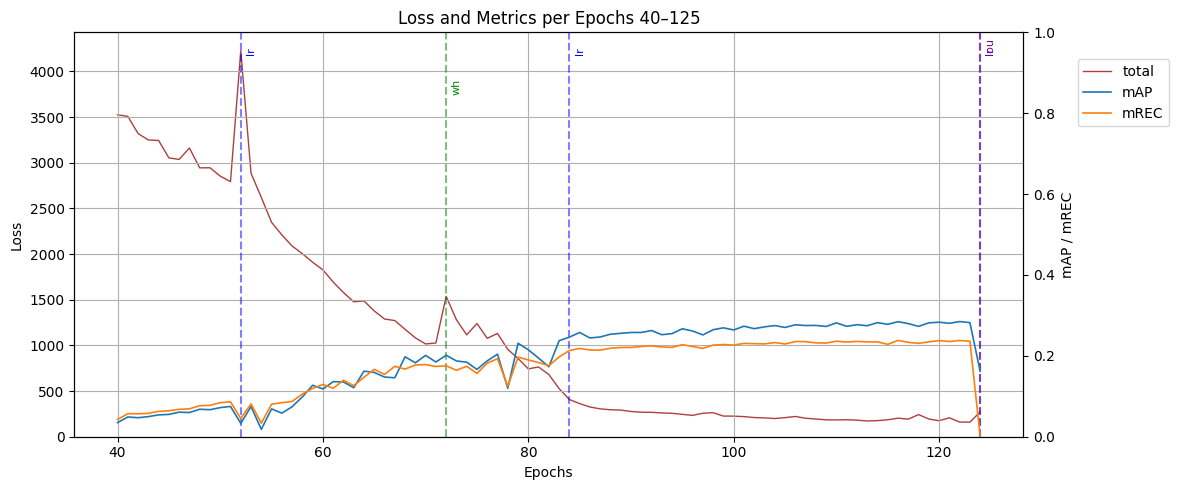

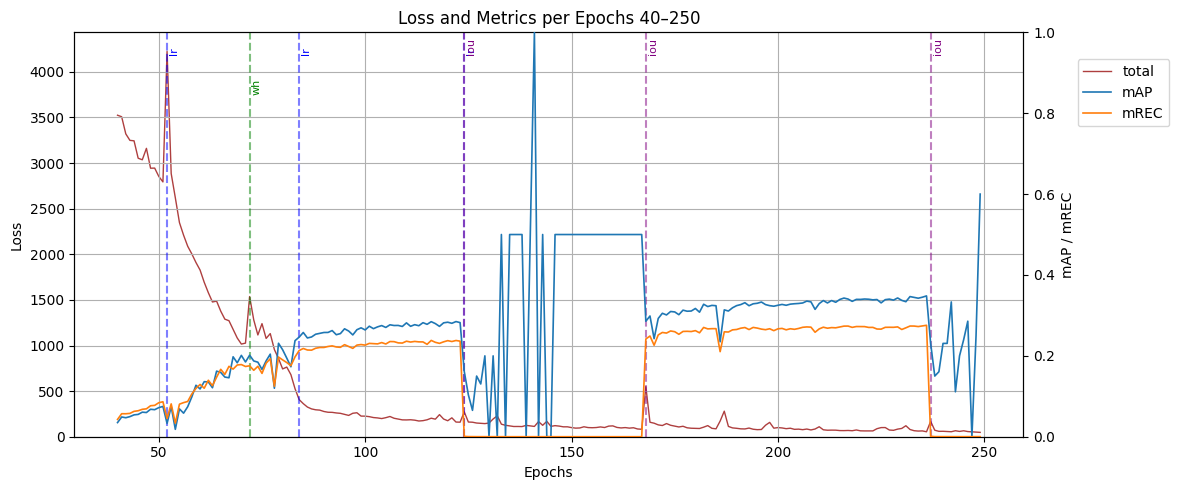

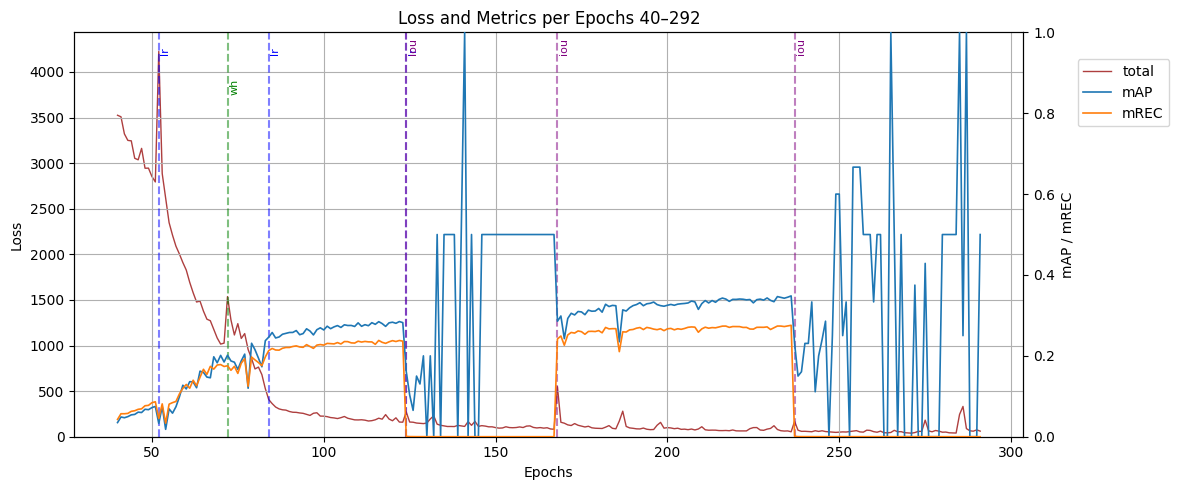

In [ ]:
def plotTraining(start, end, name, total, save):
   filepath = os.path.join(os.getcwd(), "presentation", "training_plots", f"{name}_{start}_{end}")
   # guard against out-of-range
   end = min(end, len(records))

   # detect parameter changes
   lr_change  = records[records["c_lr"].diff()     != 0].index
   wh_change  = records[records["c_wh"].diff()     != 0].index
   iou_change = records[records["iou_obj"].diff()  != 0].index

   # restrict to visible window
   lr_change  = lr_change[(lr_change  >= start) & (lr_change  < end)]
   wh_change  = wh_change[(wh_change  >= start) & (wh_change  < end)]
   iou_change = iou_change[(iou_change >= start) & (iou_change  < end)]

   fig, ax1 = plt.subplots(figsize=(15, 5))

   # left axis: losses
   # for loss, label in zip(losses, labels):
   for loss, label in zip(losses, labels):
      if not total:
         if label not in ["mAP", "mREC", "total"]:
            ax1.plot(epochs[start:end], loss[start:end], label=label, alpha=0.9, linewidth=1.0, zorder=1)
      else:
         if label == "total":
            ax1.plot(epochs[start:end], loss[start:end], label=label, alpha=0.9, linewidth=1.0, zorder=1, color="brown")
         


   ax1.set_xlabel("Epochs")
   ax1.set_ylabel("Loss")
   ax1.grid(True)

   # vertical markers
   def add_markers(ax, idxs, tag, color, yfac=0.95):
      for idx in idxs:
         ax.axvline(x=idx, color=color, linestyle='--', alpha=0.5)
         ax.text(idx + 0.5, ax.get_ylim()[1] * yfac, tag,
                  color=color, rotation=90, fontsize=8)

   add_markers(ax1, lr_change,  'lr',  'blue',   0.95)
   add_markers(ax1, iou_change, 'iou', 'purple', 0.95)
   add_markers(ax1, wh_change,  'wh',  'green',  0.85)

   # right axis: metrics
   ax2 = ax1.twinx()
   for loss, label in zip(losses, labels):
      if label in ["mAP", "mREC"]:
         ax2.plot(
               epochs[start:end], loss[start:end],
               label=label, linewidth=1.2, markersize=3.5,
               markevery=max(1, (end-start)//15), zorder=3
         )

   ax2.set_ylabel("mAP / mREC")
   ax2.set_ylim(0, 1.0)
   ax1.set_ylim(bottom=0)
   ax2.set_ylim(bottom=0)
   

   # combine legends
   lines, labels1 = ax1.get_legend_handles_labels()
   lines2, labels2 = ax2.get_legend_handles_labels()
   #ax1.legend(lines + lines2, labels1 + labels2, loc="upper right")
   # ax1.legend(lines + lines2, labels1 + labels2,
   #         loc="center left", bbox_to_anchor=(1.01, 0.5))
   #plt.tight_layout(rect=[0, 0, 0.85, 1])  # shrink plot to 85%
   ax1.legend(lines + lines2, labels1 + labels2,
           loc="center left", bbox_to_anchor=(1.05, 0.85))

   plt.title(f"Loss and Metrics per Epochs {start}–{end}")
   #plt.tight_layout()
   plt.tight_layout(rect=[0, 0, 0.8, 1])  # keep 90% for plot, 10% for legend
   if save:
      #plt.savefig(filepath)
      plt.savefig(filepath, bbox_inches="tight", pad_inches=0.05)
   
   plt.show()
   
for (start, end) in intervals:
   plotTraining(start, end, "total", True, True)
